## BERT

In [ ]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 26.1 MB/s 
     |████████████████████████████████| 132 kB 67.5 MB/s 
     |████████████████████████████████| 880 kB 33.5 MB/s 
     |████████████████████████████████| 1.3 MB 38.9 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 9.3 MB 47.3 MB/s 
     |████████████████████████████████| 140 kB 47.0 MB/s 
     |████████████████████████████████| 127 kB 44.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=ceb81cf48e03cfa2cc934596890657f55f575465d47398f1a063aa98898b5bdf
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalle

In [ ]:
import torch
from pytorch_transformers import *
import numpy as np
from sklearn.model_selection import train_test_split

import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Similar_company/train_data.csv')

In [ ]:
df.head()

,name_1,name_2,is_duplicate
0,Texxon Chemicals Inc,AL,0
1,Morgan Polimer Seals S De Rl De Cv,Usa,0
2,Weiler,Shanghai Jixiang Automobile Roof Trimming Co Ltd,0
3,M Company NYSEMMM,ROGITEX,0
4,Hershey Trading Gmb H,MB,0


In [ ]:
df_true = df.loc[df.is_duplicate==1]

In [ ]:
df_true.shape

(3118, 3)

In [ ]:
df_false = df.loc[df.is_duplicate==0]
df_false = df_false.iloc[:6000, :]

In [ ]:
df_new = pd.concat((df_true, df_false))

In [ ]:
df_new.shape

(9118, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_new[['name_1', 'name_2']], df_new.is_duplicate, test_size=0.25, random_state=222, shuffle=True, stratify=df_new.is_duplicate)

In [ ]:
model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')

# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

100%|██████████| 267967963/267967963 [00:10<00:00, 26437883.60B/s]


In [ ]:
#преобразуем каждый отзыв в список идентификаторов.
# tokenized = df.iloc[:,0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

train_name1 = x_train.iloc[:,0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
train_name2 = x_train.iloc[:,1].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
#добавим в конец нули, чтобы выровнять по длине отзывы
max_len = 0
for i in train_name1.values:
    if len(i) > max_len:
        max_len = len(i)
        
for i in train_name2.values:
    if len(i) > max_len:
        max_len = len(i)

padded_name1 = np.array([i + [0]*(max_len-len(i)) for i in train_name1.values])
padded_name2 = np.array([i + [0]*(max_len-len(i)) for i in train_name2.values])

In [ ]:
# создадим входной вектор из матрицы токенов и передадим его в DistilBERT
input_ids1 = torch.tensor(np.array(padded_name1)).to(torch.int64)
input_ids2 = torch.tensor(np.array(padded_name2)).to(torch.int64)



In [ ]:
input_ids1[:2]

tensor([[  101,  2561, 14955,  8337, 11867,  1062,  1051,  2080,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 26822,  2248,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [ ]:
embedding1=[]

for i in range(0,6838,26):
    dd = input_ids1[i:i+26]      
    with torch.no_grad():
        last_hidden_states1 = model(dd)
    embedding1.extend(last_hidden_states1[0].numpy())

In [ ]:
embedding2=[]

for i in range(0,6838,26):
    dd = input_ids2[i:i+26]      
    with torch.no_grad():
        last_hidden_states2 = model(dd)
    embedding2.extend(last_hidden_states2[0].numpy())

In [ ]:
np.array(embedding1).shape

(6838, 29, 768)

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Bidirectional, Add, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from keras import regularizers

In [ ]:
import keras.backend as K
import tensorflow as tf

def energy_loss(y_true, y_pred):
    return K.exp(-K.abs(y_true - y_pred))


class Diff(Add):
    def _merge_function(self, inputs):
        return K.sum(K.abs(inputs[1] - inputs[0]), axis=-1, keepdims=True)

    # def _compute_elemwise_op_output_shape(self, shape1, shape2):
    #     return None, None, 1

    def compute_output_shape(self, input_shape):
        output_shape = (1,)

        batch_sizes = [s[0] for s in input_shape if s is not None]
        batch_sizes = set(batch_sizes)
        batch_sizes -= {None}
        if len(batch_sizes) == 1:
            output_shape = (list(batch_sizes)[0],) + output_shape
        else:
            output_shape = (None,) + output_shape
        return output_shape


class ExpDiff(Diff):
    def _merge_function(self, inputs):
        diff = K.abs(inputs[1] - inputs[0])
        sdiff = K.sqrt(K.sum(K.square(diff), axis=-1, keepdims=True))
        score = K.exp(-sdiff)
        neg_score = 1 - score
        return K.concatenate([score, neg_score])
        # return K.exp(-diff)

    def compute_output_shape(self, input_shape):
        output_shape = (2,)

        batch_sizes = [s[0] for s in input_shape if s is not None]
        batch_sizes = set(batch_sizes)
        batch_sizes -= {None}
        if len(batch_sizes) == 1:
            output_shape = (list(batch_sizes)[0],) + output_shape
        else:
            output_shape = (None,) + output_shape
        return output_shape

class CosineDist(Diff):
    def _merge_function(self, inputs):
        l, r = inputs[0], inputs[1]
        num = K.sum((l * r), keepdims=True, axis=-1)
        den = K.sqrt(K.sum(K.square(l), keepdims=True, axis=-1)) * K.sqrt(K.sum(K.square(r), keepdims=True, axis=-1))
        den = K.clip(den, min_value=1e-4, max_value=float('inf'))
        sim = num / den
        return K.ones_like(sim) - sim

    def _compute_elemwise_op_output_shape(self, shape1, shape2):
        return None, 1

    def compute_output_shape(self, input_shape):
        return None, 1


@tf.function
def mean_rectified_infinity_loss(y_true, y_pred):

    k = 5.0
    cond = K.equal(y_true, K.zeros_like(y_true))        
    err = tf.where(cond, K.square(y_pred),
                   k/K.square(K.clip(y_pred, min_value=K.epsilon(), max_value=float('inf'))))

    return K.mean(err, axis=-1)

In [ ]:
from keras import backend as K


def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)


@tf.function
def cosine_vectorized(vec):
    array1, array2 = vec
    sumyy = K.sum(array2**2, axis=1, keepdims=1)
    sumxx = K.sum(array1**2, axis=1, keepdims=1)
    sumxy = K.dot(array1, K.transpose(array2))
    sumxy = tf.linalg.diag_part(sumxy)
    sumxy = tf.reshape(sumxy, [-1,1])
    return (sumxy/K.sqrt(sumxx))/K.sqrt(sumyy)




In [ ]:
input_1 = Input((29,768))
input_2 = Input((29,768))

x1 = (Bidirectional(LSTM(256, implementation=1,
                         return_sequences=True,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(input_1)

x1 = (Bidirectional(LSTM(128, implementation=1,
                         return_sequences=True,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x1)

x1 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='sigmoid',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x1)

x1 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x1)            


x2 = (Bidirectional(LSTM(256, implementation=1,
                         return_sequences=True,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(input_2)

x2 = (Bidirectional(LSTM(128, implementation=1,
                         return_sequences=True,
                         dropout=0.1,
                         activation='tanh',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x2)

x2 = (Bidirectional(LSTM(64, implementation=1,
                         return_sequences=False,
                         dropout=0.1,
                         activation='sigmoid',
                         recurrent_dropout=0.1,
                         kernel_regularizer=regularizers.l2(0.03))))(x2)

x2 = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.03))(x2)    


# Diff_layer = Diff()
# merged = Diff_layer([x1, x2])
out = Lambda(cosine_vectorized, output_shape=cos_dist_output_shape)([x1, x2])
# out = Dense(1, 'sigmoid')(out)
model = Model(inputs=(input_1, input_2), outputs=out)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
embedding1 = np.array(embedding1)
embedding2 = np.array(embedding2)

In [ ]:
model.fit([embedding1, embedding2], y_train.values, epochs=20, batch_size=24, validation_split=0.2)

Epoch 1/20
228/228 [==============================] - 530s 2s/step - loss: 19.6620 - accuracy: 0.6435 - val_loss: 0.6651 - val_accuracy: 0.6857
Epoch 2/20
228/228 [==============================] - 479s 2s/step - loss: 0.6669 - accuracy: 0.6410 - val_loss: 0.6401 - val_accuracy: 0.6857
Epoch 3/20
185/228 [=======================>......] - ETA: 1:25 - loss: 0.6550 - accuracy: 0.6505

KeyboardInterrupt: ignored

In [ ]:
a = model.predict([embedding1[:15], embedding2[:15]])

1/1 [==============================] - 4s 4s/step


In [ ]:
a

array([[0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449817],
       [0.36449814],
       [0.36449814],
       [0.36449814]], dtype=float32)

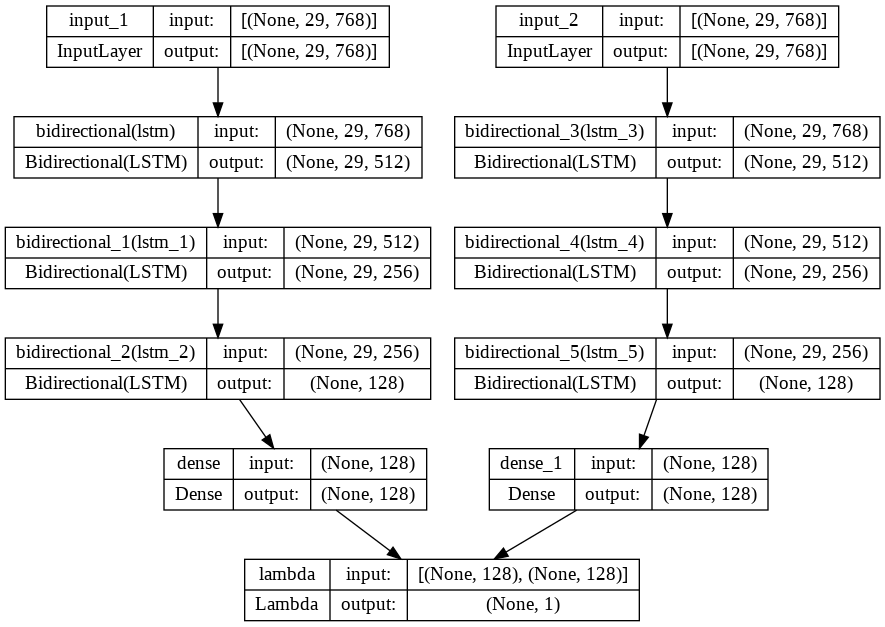

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
def cosine_vectorized(array1, array2):
    sumyy = (array2**2).sum(1,keepdims=1)
    sumxx = (array1**2).sum(1,keepdims=1)
    sumxy = array1.dot(array2.T)
    sumxy = np.diagonal(sumxy).reshape((-1,1))
    return (sumxy/np.sqrt(sumxx))/np.sqrt(sumyy)

In [ ]:
cosine_vectorized(embedding1[20][:10], embedding2[20][:10])

array([[0.964063  ],
       [0.537345  ],
       [0.46890563],
       [0.5098118 ],
       [0.34043968],
       [0.31986386],
       [0.56831455],
       [0.98877907],
       [0.96391267],
       [0.96990794]], dtype=float32)

## Tf-idf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Similar_company/train_data.csv')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df[['name_1', 'name_2']], df.is_duplicate, test_size=0.25, random_state=222, shuffle=True, stratify=df.is_duplicate)

In [ ]:
x_train.head()

,name_1,name_2
125504,HYDROTECH MEMBRANES,PUMA ENERGY ESPANA
273742,Dc Logistics,Suzhou Kintetsu Logistics Co Ltd
150308,Chand Engineering,Venus Engineering Co
199756,Shenzhen Green Sun Mould Co Ltd,Ncm International Co Ltd
395769,Thermwell Products Co,HR International


In [ ]:
x_train['is_duplicate'] = y_train

In [ ]:
df_for_tfidf = np.hstack([x_train.name_1.values, x_train.name_2.values])

In [ ]:
tfv = TfidfVectorizer(min_df=5, max_df=2000)
tfv.fit(df_for_tfidf)
# tf_idf_1 = tfv.transform(x_train.name_1)
# tf_idf_2 = tfv.transform(x_train.name_2)
dict_words = tfv.vocabulary_
key_words = dict_words.keys()

In [ ]:
# def frequency_filter(df, key_words):
#     duplicate=[]
#     not_duplicate=[]
#     for name_1, name_2, dub in df.values:
#         n=0
#         for word in name_1.lower().split():        
#             if (word in key_words) and (word in name_2.lower().split()): 
#                 n+=1
#         if n > 0:
#             duplicate.append([name_1, name_2, dub])
#         else:
#             not_duplicate.append([name_1, name_2, dub])
#     return (pd.DataFrame(duplicate, columns=df.columns), pd.DataFrame(not_duplicate, columns=df.columns))

In [ ]:
def frequency_filter(df, key_words):
    labels = []
    for name_1, name_2, dub in df.values:
        n=0
        for word in name_1.lower().split():        
            if (word in key_words) and (word in name_2.lower().split()): 
                n+=1
        if n > 0:
            labels.append(1)
        else:
            labels.append(0)
    df['predict'] = labels
    return df

In [ ]:
# duplicate, not_duplicate = frequency_filter(x_train, key_words)

In [ ]:
df_after_tfidf = frequency_filter(x_train, key_words)

In [ ]:
# def get_result(duplicate, not_duplicate):

#     print('Всего отфильтрованных, как разные: ' , not_duplicate.shape[0])
#     print('Из них ошибочно отфильтрованы, как разные: ' , not_duplicate.is_duplicate.sum())
#     print()
#     print('Всего отфильтрованных, как одинаковые: ' , duplicate.shape[0])
#     print('Из них правильно отфильтрованы, как одинаковые: ' , duplicate.is_duplicate.sum())
#     pass

In [ ]:
def get_result(df):

    print('Всего отфильтрованных, как разные: ' , df.loc[df.predict==0, 'predict'].shape[0])
    print('Из них ошибочно отфильтрованы, как разные: ' , df.loc[(df.predict==0)&(df.is_duplicate==1)].shape[0])
    print()
    print('Всего отфильтрованных, как одинаковые: ' , df.loc[df.predict==1, 'predict'].shape[0])
    print('Из них правильно отфильтрованы, как одинаковые: ' , df.loc[(df.predict==1)&(df.is_duplicate==1)].shape[0])
    pass

In [ ]:
get_result(df_after_tfidf)

Всего отфильтрованных, как разные:  317023
Из них ошибочно отфильтрованы, как разные:  77

Всего отфильтрованных, как одинаковые:  13801
Из них правильно отфильтрованы, как одинаковые:  2261


In [ ]:
words=''
for name_1, name_2 in df_after_tfidf.loc[df_after_tfidf.predict==1, ['name_1', 'name_2']].values:
    words = words + name_1 + ' ' + name_2 + ' '

words = set(words.lower().split())

In [ ]:
def word_count_in_title(words, df, duplicate=True) -> dict:
    word_count_dict={}
    for word in words:
        cnt=0
        for company_name in df.loc[(df.predict==1)&(df.is_duplicate==duplicate), ['name_1']].values:
            company_name = company_name[0].lower().split()
            if word in company_name:
                cnt+=1
        word_count_dict[word] = cnt  
    return word_count_dict


dict_positive = word_count_in_title(words, df_after_tfidf)
dict_negative = word_count_in_title(words, df_after_tfidf, False)


In [ ]:
word_importance = {}
for word in words:
    try: 
        value = dict_positive[word] / (dict_positive[word] + dict_negative[word])
    except ZeroDivisionError: 
        value = 0
    word_importance[word] = value

In [ ]:
# def filter_by_importance(df, dict_importance):
#     duplicate=[]
#     not_duplicate=[]
#     for name_1, name_2, dub, pred in df.values:
#         n=0
#         words = name_1.lower().split() 
#         # max_value = np.argmax([dict_value[word] for word in i_name])  
#         if (dict_importance.setdefault(words[0], 0) > 0.4) and (words[0] in name_2.lower().split()):
#             n+=1
#         else:
#             for word in words[1:]:
#                 if (dict_importance.setdefault(words[0], 0) > 0.7) and (word in name_2.lower().split()):
#                     n+=1

#         if n>0:
#             duplicate.append([name_1, name_2, dub])
#         else:
#             not_duplicate.append([name_1, name_2, dub])

#     return (pd.DataFrame(duplicate, columns=df.columns), pd.DataFrame(not_duplicate, columns=df.columns))

In [ ]:
def filter_by_importance(df, dict_importance):
    labels=[]
    for name_1, name_2, dub, _ in df.loc[df.predict==1].values:
        n=0
        words = name_1.lower().split() 
        # max_value = np.argmax([dict_value[word] for word in i_name])  
        if (dict_importance.setdefault(words[0], 0) > 0.4) and (words[0] in name_2.lower().split()):
            n+=1
        else:
            for word in words[1:]:
                if (dict_importance.setdefault(words[0], 0) > 0.7) and (word in name_2.lower().split()):
                    n+=1

        if n>0:
            labels.append(1)
        else:
            labels.append(0)
    df.loc[df.predict==1, 'predict'] = labels

    return df

In [ ]:
df_with_predict = filter_by_importance(df_after_tfidf, word_importance)

In [ ]:
get_result(df_with_predict)

Всего отфильтрованных, как разные:  328542
Из них ошибочно отфильтрованы, как разные:  234

Всего отфильтрованных, как одинаковые:  2282
Из них правильно отфильтрованы, как одинаковые:  2104


In [ ]:
print('Precision: ', precision_score(df_with_predict['is_duplicate'], df_with_predict['predict']))
print('Recall: ', recall_score(df_with_predict['is_duplicate'], df_with_predict['predict']))

Precision:  0.9219982471516214
Recall:  0.8999144568006844


### Проверка на тестовой выборке

In [ ]:
x_test.head()

,name_1,name_2,is_duplicate,predict
165460,North American Wood Products,Iris Products SADe CV,0,0
196743,Gestion Soprema Canada Inc,VALLI ZABBAN,0,0
406708,Les Tricots Duval And Raymond,Tes Uk,0,0
30669,Ss Trade Inc,Foshan City Yi Si High Trade Co Ltd,0,0
323247,Hangzhou Industrial Co Ltd,Gti International Pvt Ltd,0,0


In [ ]:
x_test['is_duplicate'] = y_test

In [ ]:
test_after_tfidf = frequency_filter(x_test, key_words)

In [ ]:
get_result(test_after_tfidf)

Всего отфильтрованных, как разные:  105498
Из них ошибочно отфильтрованы, как разные:  39

Всего отфильтрованных, как одинаковые:  4777
Из них правильно отфильтрованы, как одинаковые:  741


In [ ]:
test_with_predict = filter_by_importance(test_after_tfidf, word_importance)

In [ ]:
get_result(test_with_predict)

Всего отфильтрованных, как разные:  4019
Из них ошибочно отфильтрованы, как разные:  64

Всего отфильтрованных, как одинаковые:  758
Из них правильно отфильтрованы, как одинаковые:  677


In [ ]:
print('Precision: ', precision_score(test_with_predict['is_duplicate'], test_with_predict['predict']))
print('Recall: ', recall_score(test_with_predict['is_duplicate'], test_with_predict['predict']))

Precision:  0.8931
Recall:  0.8679


## Embedding